# 案例目标

给定一段时间内的北京天气相关指数数据和北京PM2.5指数等，建立模型预测接下来一段时间内北京的PM2.5指数。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns   
import warnings
warnings.filterwarnings('ignore')  # 忽略警告

from IPython.core.interactiveshell import InteractiveShell   # 多行输出
InteractiveShell.ast_node_interactivity = "all"

# 探索数据

## 读取数据

In [3]:
train = pd.read_csv('pm25_train.csv')
train.head()
test = pd.read_csv('pm25_test.csv')
test.head()

,date,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
0,2010-01-02,0,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
1,2010-01-02,1,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2,2010-01-02,2,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
3,2010-01-02,3,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
4,2010-01-02,4,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


,date,hour,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
0,2010-01-07,0,-21,-16.0,1035.0,8.95,0,0,0,1,0,0
1,2010-01-07,1,-21,-16.0,1035.0,0.45,0,0,0,0,0,1
2,2010-01-07,2,-22,-18.0,1036.0,1.34,0,0,0,0,0,1
3,2010-01-07,3,-23,-15.0,1036.0,4.02,0,0,0,1,0,0
4,2010-01-07,4,-24,-16.0,1035.0,7.15,0,0,0,1,0,0


| 字段名称 | 字段说明                                           |
| -------- | -------------------------------------------------- |
| date     | 观测数据发生的日期（年-月-日）                     |
| hour     | 观测数据发生的时间点（时）                         |
| pm2.5    | 观测时间点对应的pm2.5指数（ug/m^3）                |
| DEWP     | 露点，空气中水气含量达到饱和的气温（$\hat{a},f$ ） |
| TEMP     | 温度，观测时间点对应的温度（$\hat{a},f$）          |
| PRES     | 压强，观测时间点对应的压强（hPa）                  |
| lws      | 累计风速，观测时间点对应的累计风速（m/s）          |
| ls       | 累计降雪，到观测时间点为止累计降雪的时长（小时）   |
| lr       | 累计降雨，到观测时间点为止累计降雨的时长（小时）   |
| cbwd_NE  | 观测时间点对应的风向为东北风（m/s）                |
| cbwd_NW  | 观测时间点对应的风向为西北风（m/s）                |
| cbwd_SE  | 观测时间点对应的风向为东南风（m/s）                |
| cbwd_cv  | 观测时间点对应的风向为静风（m/s）                  |

## 数据结构和基本信息

In [521]:
train.shape  # 查看数据结构
train.info()   # 查看数据的基本信息
train.isnull().mean()    # 是否有缺失值

(35746, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35746 entries, 0 to 35745
Data columns (total 13 columns):
date       35746 non-null object
hour       35746 non-null int64
pm2.5      35746 non-null float64
DEWP       35746 non-null int64
TEMP       35746 non-null float64
PRES       35746 non-null float64
Iws        35746 non-null float64
Is         35746 non-null int64
Ir         35746 non-null int64
cbwd_NE    35746 non-null int64
cbwd_NW    35746 non-null int64
cbwd_SE    35746 non-null int64
cbwd_cv    35746 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 3.5+ MB


date       0.0
hour       0.0
pm2.5      0.0
DEWP       0.0
TEMP       0.0
PRES       0.0
Iws        0.0
Is         0.0
Ir         0.0
cbwd_NE    0.0
cbwd_NW    0.0
cbwd_SE    0.0
cbwd_cv    0.0
dtype: float64

In [4]:
train.describe().T   # 查看总体的统计信息

,count,mean,std,min,25%,50%,75%,max
hour,35746.0,11.509819,6.924821,0.00,6.00,12.00,18.00,23.00
pm2.5,35746.0,98.805097,92.006764,0.00,29.00,73.00,137.00,994.00
DEWP,35746.0,1.779500,14.336290,-40.00,-10.00,2.00,15.00,28.00
TEMP,35746.0,12.413641,12.165962,-19.00,2.00,14.00,23.00,41.00
PRES,35746.0,1016.427614,10.253854,992.00,1008.00,1016.00,1025.00,1046.00
Iws,35746.0,23.717183,48.847511,0.45,1.79,5.37,21.92,565.49
Is,35746.0,0.057489,0.790715,0.00,0.00,0.00,0.00,27.00
Ir,35746.0,0.203463,1.485673,0.00,0.00,0.00,0.00,36.00
cbwd_NE,35746.0,0.114223,0.318086,0.00,0.00,0.00,0.00,1.00
cbwd_NW,35746.0,0.320176,0.466550,0.00,0.00,0.00,1.00,1.00


## 需要预测的目标

偏度：1.811953
峰度：4.915487


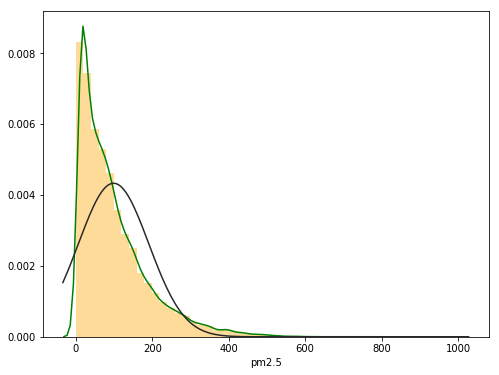

In [6]:
from scipy import stats   # 统计学算法库
plt.figure(figsize=(8,6))
# 概率密度分布图
sns.distplot(train['pm2.5'],hist_kws={'color':'orange'},kde_kws={'color':'green'},fit=stats.norm)
print('偏度：%f' % train['pm2.5'].skew())
print('峰度：%f' % train['pm2.5'].kurt());

通过对标签pm2.5值的正态分布可能性检测，偏度是右偏的，峰度是4.9左右，与正态分布相距较远。

((array([-4.11462207, -3.90523093, -3.79092845, ...,  3.79092845,
          3.90523093,  4.11462207]),
  array([  0.,   0.,   1., ..., 972., 980., 994.])),
 (84.02522453800752, 98.80509707379844, 0.9131604895345479))

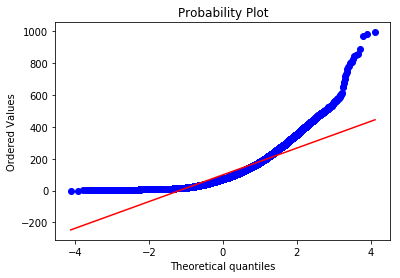

In [7]:
fig = plt.figure()
stats.probplot(train['pm2.5'],plot=plt)

probplot函数计算出了一个当前样本最可能的线性分布，并用plt展示出来，我们可以直观地看到线性拟合程度并不好。

接下来我们对标签做log对数转换，然后再看看分布。数据中存在0值，做了log变换后会出现计算错误。

In [8]:
train['label']=np.log(train['pm2.5'])

数据中存在0值，做了log变换后会出现计算错误，

In [9]:
train = train.drop(train.loc[np.isinf(train['label'])].index)   # 出现计算错误的值只有2条，删除掉

偏度：-0.364670
峰度：-0.535320


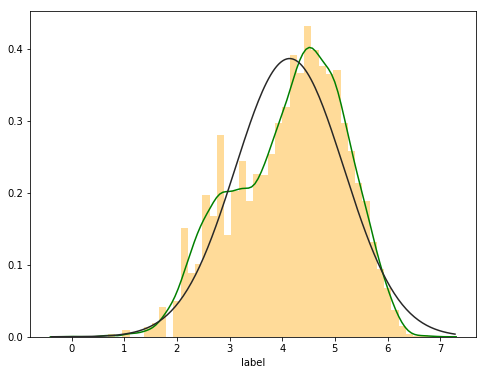

In [10]:
plt.figure(figsize=(8,6))
sns.distplot(train['label'],hist_kws={'color':'orange'},kde_kws={'color':'green'},fit=stats.norm)
print('偏度：%f' % train['label'].skew())
print('峰度：%f' % train['label'].kurt());

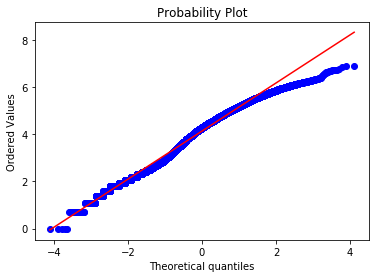

In [11]:
stats.probplot(train['label'],plot=plt); # 可以看到，经过对数转换后，分布基本上可以进行线性拟合了

# 描述性统计

## 时间字段

In [90]:
train.date.unique().min()   # 观测窗口的起始时间
train.date.unique().max()  # 观测窗口的终止时间

'2010-01-02'

'2014-12-31'

In [91]:
# 是否每一天都有记录
len(train.date.unique())    # 数据包含的天数
pd.to_datetime(train.date.unique().max())-pd.to_datetime(train.date.unique().min())   # 原始应该包含的天数

1533

Timedelta('1824 days 00:00:00')

In [92]:
# 每一天会有多条记录，并且参差不齐
train.groupby('date')['hour'].count().unique()

array([24, 17, 12, 23, 22,  7,  9, 21,  4, 10, 14, 20,  8, 19,  5,  1, 16,
        3,  6,  2, 18, 15, 13, 11])

In [93]:
'2010-5-27' in train['date']

False

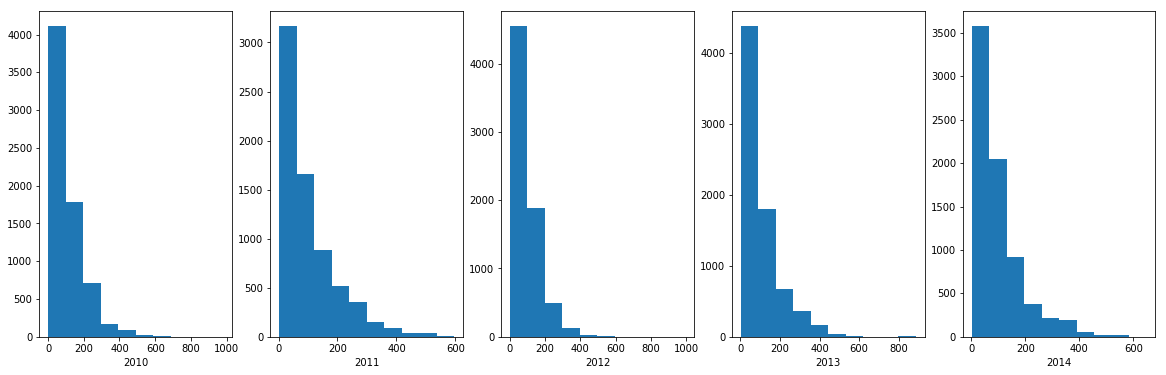

In [94]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(151)
ax1.hist(train.loc[pd.to_datetime(train['date']).dt.year==2010,:]['pm2.5'])
ax1.set_xlabel('2010');
ax2 = fig.add_subplot(152)
ax2.hist(train.loc[pd.to_datetime(train['date']).dt.year==2011,:]['pm2.5'])
ax2.set_xlabel('2011');
ax3 = fig.add_subplot(153)
ax3.hist(train.loc[pd.to_datetime(train['date']).dt.year==2012,:]['pm2.5'])
ax3.set_xlabel('2012');
ax4 = fig.add_subplot(154)
ax4.hist(train.loc[pd.to_datetime(train['date']).dt.year==2013,:]['pm2.5'])
ax4.set_xlabel('2013');
ax5 = fig.add_subplot(155)
ax5.hist(train.loc[pd.to_datetime(train['date']).dt.year==2014,:]['pm2.5'])
ax5.set_xlabel('2014');

In [95]:
def df_month(year):
    df = train.loc[pd.to_datetime(train['date']).dt.year==year,:]
    df['month']=pd.to_datetime(df['date']).dt.month
    return df

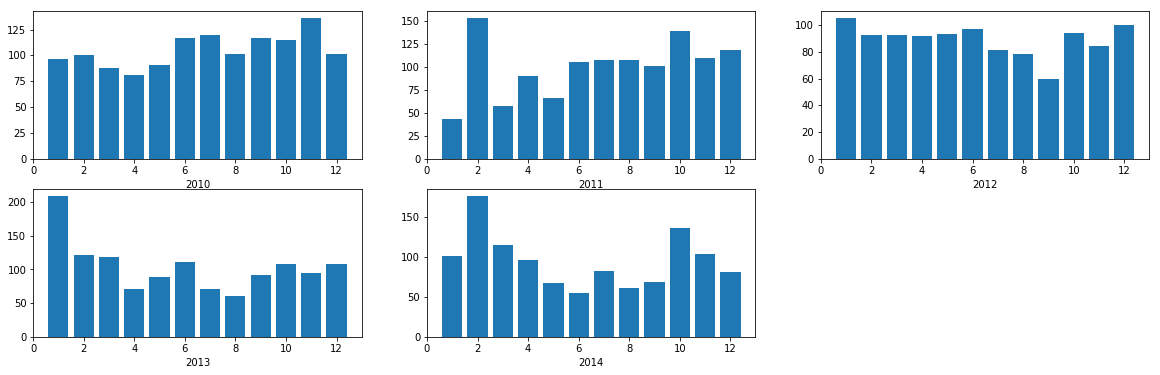

In [96]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(231)
ax1.bar(np.arange(1,13),df_month(2010).groupby('month')['pm2.5'].mean())
ax1.set_xlabel('2010');
ax2 = fig.add_subplot(232)
ax2.bar(np.arange(1,13),df_month(2011).groupby('month')['pm2.5'].mean())
ax2.set_xlabel('2011');
ax3 = fig.add_subplot(233)
ax3.bar(np.arange(1,13),df_month(2012).groupby('month')['pm2.5'].mean())
ax3.set_xlabel('2012');
ax4 = fig.add_subplot(234)
ax4.bar(np.arange(1,13),df_month(2013).groupby('month')['pm2.5'].mean())
ax4.set_xlabel('2013');
ax5 = fig.add_subplot(235)
ax5.bar(np.arange(1,13),df_month(2014).groupby('month')['pm2.5'].mean())
ax5.set_xlabel('2014');

In [97]:
df_month(2010).groupby('month')['pm2.5'].describe()

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,557.0,96.942549,98.304293,9.0,26.00,52.0,148.00,485.0
2,575.0,100.022609,86.041789,6.0,38.00,80.0,143.50,980.0
3,613.0,87.468189,83.320240,5.0,39.00,64.0,101.00,784.0
4,600.0,81.333333,75.212369,5.0,22.00,56.0,111.25,389.0
5,646.0,91.060372,61.021824,4.0,42.00,78.5,131.75,314.0
6,469.0,117.046908,51.402571,10.0,80.00,111.0,152.00,252.0
7,624.0,119.397436,71.256094,2.0,60.00,107.0,178.25,310.0
8,580.0,101.806897,69.822281,4.0,46.00,84.0,144.25,360.0
9,393.0,116.704835,79.725066,1.0,58.00,100.0,153.00,455.0


In [13]:
# 提取时间日期特征
train['day'] = pd.to_datetime(train['date']).dt.day
train['month'] = pd.to_datetime(train['date']).dt.month
train['year']  = pd.to_datetime(train['date']).dt.year
train['week'] = pd.to_datetime(train['date']).dt.week

# 数据预处理

## 标准化

In [630]:
train.head()

,date,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,label,day,month,year,week
0,2010-01-02,0,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0,4.859812,2,1,2010,53
1,2010-01-02,1,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0,4.997212,2,1,2010,53
2,2010-01-02,2,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0,5.068904,2,1,2010,53
3,2010-01-02,3,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0,5.198497,2,1,2010,53
4,2010-01-02,4,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0,4.927254,2,1,2010,53


In [631]:
feature = train.drop(['date','pm2.5','label','TEMP','PRES','hour','Is'],axis=1)

In [632]:
for i in feature.columns:
    feature[i]=feature[i].astype('float64')

In [633]:
feature.head()

,DEWP,Iws,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,day,month,year,week
0,-16.0,1.79,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2010.0,53.0
1,-15.0,2.68,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2010.0,53.0
2,-11.0,3.57,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2010.0,53.0
3,-7.0,5.36,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2010.0,53.0
4,-7.0,6.25,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2010.0,53.0


In [634]:
from sklearn.decomposition import PCA   # 主成分分析，降维，消除多重共线性

In [635]:
pca=PCA(n_components=3)     # 结果为导向
train_total=pca.fit_transform(feature)

In [636]:
pca.explained_variance_ratio_.tolist()     # 主成分解释性80%以上

[0.8254207607841504, 0.09351716848069862, 0.052671354862552]

## 计算特征的相关性

In [14]:
train.head()

,date,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,label,day,month,year,week
0,2010-01-02,0,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0,4.859812,2,1,2010,53
1,2010-01-02,1,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0,4.997212,2,1,2010,53
2,2010-01-02,2,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0,5.068904,2,1,2010,53
3,2010-01-02,3,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0,5.198497,2,1,2010,53
4,2010-01-02,4,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0,4.927254,2,1,2010,53


In [15]:
train.corr()

,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,label,day,month,year,week
hour,1.000000,-0.026518,-0.023338,0.150304,-0.042437,0.063032,-0.004525,-0.008439,-0.066621,-0.124243,0.212146,-0.053613,-0.023606,0.000582,-0.001566,-0.000368,-0.002428
pm2.5,-0.026518,1.000000,0.165051,-0.094266,-0.044580,-0.248665,0.023054,-0.056910,-0.033667,-0.209505,0.090352,0.158942,0.860516,0.081197,-0.021108,-0.022085,-0.011647
DEWP,-0.023338,0.165051,1.000000,0.823102,-0.775348,-0.289643,-0.036604,0.127103,-0.033060,-0.334056,0.272691,0.088250,0.303198,0.033919,0.232007,0.008971,0.238782
TEMP,0.150304,-0.094266,0.823102,1.000000,-0.825305,-0.149456,-0.097524,0.050511,-0.060508,-0.265860,0.307732,-0.008550,0.011474,0.023489,0.170514,0.055162,0.168626
PRES,-0.042437,-0.044580,-0.775348,-0.825305,1.000000,0.174304,0.071854,-0.084844,0.062264,0.226585,-0.248590,-0.016859,-0.153113,-0.014815,-0.063903,-0.014469,-0.053791
Iws,0.063032,-0.248665,-0.289643,-0.149456,0.174304,1.000000,0.019178,-0.005661,-0.115577,0.360069,-0.076635,-0.230237,-0.356977,-0.008099,0.017992,-0.067471,0.010227
Is,-0.004525,0.023054,-0.036604,-0.097524,0.071854,0.019178,1.000000,-0.009958,-0.006867,-0.020695,0.036301,-0.013321,0.036507,-0.039691,-0.063324,-0.017484,-0.022473
Ir,-0.008439,-0.056910,0.127103,0.050511,-0.084844,-0.005661,-0.009958,1.000000,0.038907,0.033124,-0.040293,-0.020938,-0.059517,-0.001203,0.042808,-0.022647,0.041925
cbwd_NE,-0.066621,-0.033667,-0.033060,-0.060508,0.062264,-0.115577,-0.006867,0.038907,1.000000,-0.246425,-0.263605,-0.188202,-0.063731,-0.010816,-0.009104,0.007643,-0.003096
cbwd_NW,-0.124243,-0.209505,-0.334056,-0.265860,0.226585,0.360069,-0.020695,0.033124,-0.246425,1.000000,-0.503715,-0.359629,-0.348855,-0.017928,0.040633,-0.055036,0.025886


In [ ]:
from sklearn.preprocessing import StandardScaler  # 标准化：不会改变数据的原始分布，只是做了平移和压缩

# 建模

## 划分训练集和测试集

In [637]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(train_total,train['label'],test_size=0.1,random_state=42)

## 定义评估指标

## 线性回归

In [638]:
from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE

In [639]:
Xtrain.shape

(32169, 3)

In [640]:
LR = LinearRegression().fit(Xtrain,Ytrain)
MSE(Ytest,LR.predict(Xtest))   # 自己划分的测试集，仍然是历史数据，只能作为参考，调参的参考

0.8556037979581627

# 预测（和训练集做相同的操作）

In [641]:
test.head()

,date,hour,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
0,2010-01-07,0,-21,-16.0,1035.0,8.95,0,0,0,1,0,0
1,2010-01-07,1,-21,-16.0,1035.0,0.45,0,0,0,0,0,1
2,2010-01-07,2,-22,-18.0,1036.0,1.34,0,0,0,0,0,1
3,2010-01-07,3,-23,-15.0,1036.0,4.02,0,0,0,1,0,0
4,2010-01-07,4,-24,-16.0,1035.0,7.15,0,0,0,1,0,0


In [644]:
# 提取时间日期特征
test['day'] = pd.to_datetime(test['date']).dt.day
test['month'] = pd.to_datetime(test['date']).dt.month
test['year']  = pd.to_datetime(test['date']).dt.year
test['week'] = pd.to_datetime(test['date']).dt.week

In [645]:
test_feature = test.drop(['date','TEMP','PRES','hour','Is'],axis=1)
test_feature.head()

,DEWP,Iws,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,day,month,year,week
0,-21,8.95,0,0,1,0,0,7,1,2010,1
1,-21,0.45,0,0,0,0,1,7,1,2010,1
2,-22,1.34,0,0,0,0,1,7,1,2010,1
3,-23,4.02,0,0,1,0,0,7,1,2010,1
4,-24,7.15,0,0,1,0,0,7,1,2010,1


In [646]:
for i in test_feature.columns:
    test_feature[i]=test_feature[i].astype('float64')

In [647]:
pca=PCA(n_components=3)
test_total=pca.fit_transform(test_feature)
pca.explained_variance_ratio_

array([0.84975294, 0.08107059, 0.04632514])

In [648]:
Ypred = LR.predict(test_total)  # 得到预测值（对数结果）

In [651]:
solution = pd.DataFrame({'pm2.5':np.round(np.exp(Ypred))})
solution

,pm2.5
0,56.0
1,59.0
2,57.0
3,56.0
4,54.0
5,52.0
6,51.0
7,53.0
8,55.0
9,54.0


In [652]:
solution.to_csv('solution.csv',encoding = "utf-8",header=1,index=0)